In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from joblib import dump, Parallel, delayed

from sklearn.datasets import fetch_openml

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, recall_score, precision_score, f1_score,
                            classification_report, confusion_matrix)
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression



In [2]:
# Ladda in MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
# Ladda MNIST 'data' in på X och 'target' in på y
X = mnist['data']
y = mnist['target']



In [4]:
# Ladda in beskrivningen av datasetet
mnist['DESCR']


"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

In [5]:
target_names=np.unique(mnist.target)
print(target_names)

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


## EDA

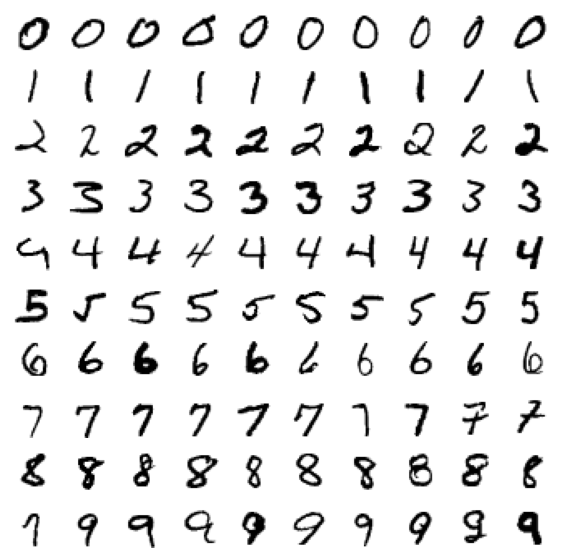

In [6]:
# Skapa en figur med 10x10 subplots för att visa exempel på MNIST dataset
y=y.astype(int) 
X_array=X.values  
def exempel_bild(data, label):
    fig, axes = plt.subplots(10, 10, figsize=(7,7))
    # Hittar index för alla exempel av aktuell siffra
    for i in range(10):  
        index = np.where(label == i)[0]
        # Väljer 10 unika bilder för varje siffra
        for j in range(10):
            vald_index = np.random.choice(index, size=1, replace=False)
            ax = axes[i, j]
            ax.imshow(data[vald_index[0]].reshape(28, 28), cmap='binary')
            ax.axis('off')
    plt.show()
          
exempel_bild(X_array, y)


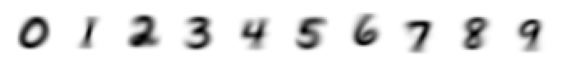

In [7]:
# Beräknar medelbilden för alla instanser av den aktuella siffran. Medelbilden beräknas genom att ta 
# medelvärdet av varje pixelintensitet för varje position över alla bilder som motsvarar siffran 'i'
def median_bild(data, label):
    fig, axes = plt.subplots(1, 10, figsize=(7, 1))
    for i in range(10):
        mean_img = data[label == i].mean(axis=0)
        ax = axes[i]
        ax.imshow(mean_img.reshape(28, 28), cmap='binary')
        ax.axis('off')

median_bild(X_array, y)


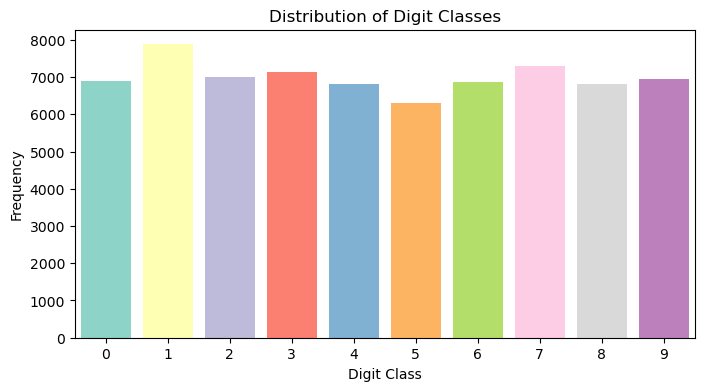

In [8]:
#  Visualizing the distribution of digit classes in the dataset 
df = pd.DataFrame(y, columns=['class'])
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='class', hue='class', palette='Set3', saturation=1, dodge=False)
plt.title('Distribution of Digit Classes')
plt.xlabel('Digit Class')
plt.ylabel('Frequency')
plt.legend().set_visible(False)




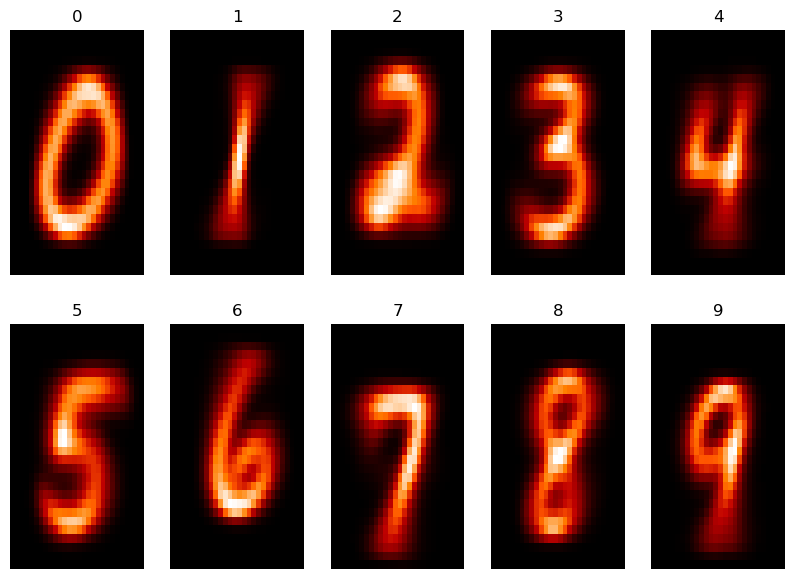

In [9]:
# Medelvärdet för varje pixel i en heatmap i en 2x5 rutnät
def heatmaps_median_img(data, labels):
    fig, axes = plt.subplots(2, 5, figsize=(10, 7))
    for i in range(10):
        img_data = data[labels == i]  
        mean_img = np.mean(img_data, axis=0) # Beräknar medelvärdet per rad
        # Reshape för mean_img shape, måste vara 2D istället för 1D
        row_index = i // 5
        col_index = i % 5
        sns.heatmap(mean_img.reshape(28,28), ax=axes[row_index, col_index], cbar=False, cmap='gist_heat')
        axes[row_index, col_index].axis('off')
        axes[row_index, col_index].set_title(i)

heatmaps_median_img(X_array, y)



In [10]:
# Översikt över hur pixelvärden representerar siffrorna i datasetet
for i in range(10):
    index = np.where(y == i)[0]
    for j in range(10):
        vald_index = np.random.choice(index, size=1, replace=False)
        first_image = X_array[vald_index]  
        image_matrix = first_image.reshape(28, 28)  
        np.set_printoptions(linewidth=np.inf)
    print(image_matrix)
    print()
    print()


[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  19.  38.  38.  19.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  96. 218. 253. 253. 218. 158.  15.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  22. 221. 253. 253. 253. 253. 253. 228.  61.   2.   0.   0.   0.   0.   0.   0.   0.]

## Split


In [11]:
# Vanlig train test split med validation
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, random_state=42)



In [12]:
# Stratified Shuffle Split

sss_initial = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss_initial.split(X, y):
    X_train_test_sss, X_test_sss = X.iloc[train_index], X.iloc[test_index]
    y_train_test_sss, y_test_sss = y.iloc[train_index], y.iloc[test_index]

sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)  
for train_index, val_index in sss_val.split(X_train_test_sss, y_train_test_sss):
    X_train_sss, X_val_sss = X_train_test_sss.iloc[train_index], X_train_test_sss.iloc[val_index]
    y_train_sss, y_val_sss = y_train_test_sss.iloc[train_index], y_train_test_sss.iloc[val_index]


## Modell


In [13]:

results = []

In [29]:
# Vanlig split: SVM, Logistic Regression, KNN
# Implementera MinMaxScaler och PCA

pipelines = {
    'SVM': Pipeline([
        ('scaler', MinMaxScaler()),
        ('pca', PCA(n_components=0.95)),
        ('model', SVC(random_state=42))
    ]),
    'Logistic Regression': Pipeline([
        ('scaler', MinMaxScaler()),
        ('pca', PCA(n_components=0.95)),
        ('model', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'KNearestNeighbors': Pipeline([
        ('scaler', MinMaxScaler()),
        ('pca', PCA(n_components=0.95)),
        ('model', KNeighborsClassifier())
    ])
}


def fit_model(pipeline, model_name, X_train, y_train, X_val, y_val):
    pipeline.fit(X_train, y_train)   
    prediction = pipeline.predict(X_val)
    
    return {
        'Model': model_name,
        'Split': 'Train Test Split',
        'PCA Applied': 'Ja',
        'Scaler Applied': 'Ja',
        'Accuracy': accuracy_score(y_val, prediction),
        'Recall': recall_score(y_val, prediction, average='macro'),
        'Precision': precision_score(y_val, prediction, average='macro'),
        'F1 Score': f1_score(y_val, prediction, average='macro')
    }


results.extend(Parallel(n_jobs=-1)(
    delayed(fit_model)(pipeline, model_name, X_train, y_train, X_val, y_val)
    for model_name, pipeline in pipelines.items()
))




In [30]:
# Stratified Shuffle Split: SVM, Logistic Regression, KNN
# Implementera MinMaxScaler och PCA

pipelines = {
    'SVM': Pipeline([
        ('scaler', MinMaxScaler()),
        ('pca', PCA(n_components=0.95)),
        ('model', SVC(random_state=42))
    ]),
    'Logistic Regression': Pipeline([
        ('scaler', MinMaxScaler()),
        ('pca', PCA(n_components=0.95)),
        ('model', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'KNearestNeighbors': Pipeline([
        ('scaler', MinMaxScaler()),
        ('pca', PCA(n_components=0.95)),
        ('model', KNeighborsClassifier())
    ])
}

def fit_model(pipeline, model_name, X_train_sss, y_train_sss, X_val_sss, y_val_sss):
    pipeline.fit(X_train_sss, y_train_sss)   
    prediction = pipeline.predict(X_val)
    
    return {
        'Model': model_name,
        'Split': 'Stratified Shuffle Split',
        'PCA Applied': 'Ja',
        'Scaler Applied': 'Ja',
        'Accuracy': accuracy_score(y_val, prediction),
        'Recall': recall_score(y_val, prediction, average='macro'),
        'Precision': precision_score(y_val, prediction, average='macro'),
        'F1 Score': f1_score(y_val, prediction, average='macro')
    }



results.extend(Parallel(n_jobs=-1)(
    delayed(fit_model)(pipeline, model_name, X_train_sss, y_train_sss, X_val_sss, y_val_sss)
    for model_name, pipeline in pipelines.items()
))




In [31]:
# Vanlig split: Random Forest, PCA implementeras

pipeline = Pipeline([
    ('pca', PCA(n_components=0.95)),
    ('classifier', RandomForestClassifier(random_state=42))
])

def fit_model(pipeline, X_train, y_train, X_val, y_val):
    pipeline.fit(X_train, y_train)
    prediction = pipeline.predict(X_val)
    
    return {
        'Model': 'Random Forest',
        'Split': 'Train Test Split',
        'PCA Applied': 'Ja',
        'Scaler Applied': 'Nej',  
        'Accuracy': accuracy_score(y_val, prediction),
        'Recall': recall_score(y_val, prediction, average='macro'),
        'Precision': precision_score(y_val, prediction, average='macro'),
        'F1 Score': f1_score(y_val, prediction, average='macro')
    }

results.append(fit_model(pipeline, X_train, y_train, X_val, y_val))




In [32]:
# Stratified Shuffle Split: Random Forest, PCA implementeras

pipeline = Pipeline([
    ('pca', PCA(n_components=0.95)),
    ('classifier', RandomForestClassifier(random_state=42))
])

def fit_model(pipeline,  X_train_sss, y_train_sss, X_val_sss, y_val_sss):
    pipeline.fit( X_train_sss, y_train_sss)
    prediction = pipeline.predict( X_val_sss)
    
    return {
        'Model': 'Random Forest',
        'Split': 'Stratified Shuffle Split',
        'PCA Applied': 'Ja',
        'Scaler Applied': 'Nej',  
        'Accuracy': accuracy_score(y_val_sss, prediction),
        'Recall': recall_score(y_val_sss, prediction, average='macro'),
        'Precision': precision_score(y_val_sss, prediction, average='macro'),
        'F1 Score': f1_score(y_val_sss, prediction, average='macro')
    }

results.append(fit_model(pipeline, X_train_sss, y_train_sss, X_val_sss, y_val_sss))


In [33]:
# Vanlig Split: Voting Classifier

pipelines = {
    'SVM': Pipeline([
        ('scaler', MinMaxScaler()),
        ('pca', PCA(n_components=0.95)),
        ('model', SVC(random_state=42, probability=True))
    ]),
    'Logistic Regression': Pipeline([
        ('scaler', MinMaxScaler()),
        ('pca', PCA(n_components=0.95)),
        ('model', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'KNearestNeighbors': Pipeline([
        ('scaler', MinMaxScaler()),
        ('pca', PCA(n_components=0.95)), 
        ('model', KNeighborsClassifier())
    ])
}
def voting_classifier(X_train, y_train, X_test, y_test, estimators, voting='soft'):
    voting_clf = VotingClassifier(estimators=estimators, voting=voting)
    voting_clf.fit(X_train, y_train)
    predictions = voting_clf.predict(X_test)
    
    return {
        'Model': 'Voting Classifier',
        'Split': 'Vanlig Split',
        'PCA Applied': 'Ja',
        'Scaler Applied': 'Ja',
        'Accuracy': accuracy_score(y_val, predictions),
        'Recall': recall_score(y_val, predictions, average='macro'),
        'Precision': precision_score(y_val, predictions, average='macro'),
        'F1 Score': f1_score(y_val, predictions, average='macro')
        }
   


estimators = [
    ('svm', pipelines['SVM']),
    ('logistic_regression', pipelines['Logistic Regression']),
    ('knn', pipelines['KNearestNeighbors'])
    ]



results.append(voting_classifier(X_train, y_train, X_val, y_val, estimators))




In [34]:
# Stratified Shuffle Split: Voting Classifier

pipelines = {
    'SVM': Pipeline([
        ('scaler', MinMaxScaler()),
        ('pca', PCA(n_components=0.95)),
        ('model', SVC(random_state=42, probability=True))
    ]),
    'Logistic Regression': Pipeline([
        ('scaler', MinMaxScaler()),
        ('pca', PCA(n_components=0.95)),
        ('model', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'KNearestNeighbors': Pipeline([
        ('scaler', MinMaxScaler()),
        ('pca', PCA(n_components=0.95)), 
        ('model', KNeighborsClassifier())
    ])
}
def voting_classifier(X_train_sss, y_train_sss, X_test_sss, y_test_sss, estimators, voting='soft'):
    voting_clf = VotingClassifier(estimators=estimators, voting=voting)
    voting_clf.fit(X_train_sss, y_train_sss)
    predictions = voting_clf.predict(X_test_sss)
    
    return {
        'Model': 'Voting Classifier',
        'Split': 'Stratified Shuffle Split',
        'PCA Applied': 'Ja',
        'Scaler Applied': 'Ja',
        'Accuracy': accuracy_score(y_val_sss, predictions),
        'Recall': recall_score(y_val_sss, predictions, average='macro'),
        'Precision': precision_score(y_val_sss, predictions, average='macro'),
        'F1 Score': f1_score(y_val_sss, predictions, average='macro')
        }
    


estimators = [
    ('svm', pipelines['SVM']),
    ('logistic_regression', pipelines['Logistic Regression']),
    ('knn', pipelines['KNearestNeighbors'])
    ]

results.append(voting_classifier(X_train_sss, y_train_sss, X_val_sss, y_val_sss, estimators))



In [35]:
results_df = pd.DataFrame(results)


In [36]:
results_df.head(20)

,Model,Split,PCA Applied,Scaler Applied,Accuracy,Recall,Precision,F1 Score
0,SVM,Train Test Split,Ja,Ja,0.979881,0.979683,0.979819,0.979739
1,Logistic Regression,Train Test Split,Ja,Ja,0.916190,0.914747,0.915004,0.914816
2,KNearestNeighbors,Train Test Split,Ja,Ja,0.970060,0.969456,0.970413,0.969766
3,SVM,Stratified Shuffle Split,Ja,Ja,0.987917,0.987863,0.987882,0.987865
4,Logistic Regression,Stratified Shuffle Split,Ja,Ja,0.923155,0.921773,0.921974,0.921826
5,KNearestNeighbors,Stratified Shuffle Split,Ja,Ja,0.977679,0.977190,0.978080,0.977516
6,Random Forest,Train Test Split,Ja,Nej,0.939524,0.938552,0.938866,0.938637
7,Random Forest,Stratified Shuffle Split,Ja,Nej,0.945643,0.945040,0.945134,0.944984
8,Voting Classifier,Vanlig Split,Ja,Ja,0.974464,0.974075,0.974551,0.974272
9,Voting Classifier,Stratified Shuffle Split,Ja,Ja,0.975500,0.975341,0.975622,0.975444


In [ ]:
#SVC model

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=0.95)),
    ('svc', SVC(random_state=42))
])


In [14]:
# Förfina vald model med hyperparameter

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=0.95)),
    ('svc', SVC(random_state=42))
])

# Definiera parameterrutnätet för GridSearchCV
param_grid = {
    'svc__C': [0.1, 1, 10, 100],  
    'svc__gamma': ['scale', 'auto'],  
    'svc__kernel': ['rbf'] 
}


grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_sss, y_train_sss)

print("Bästa parametrarna hittades var:", grid_search.best_params_)


best_model = grid_search.best_estimator_
predictions = best_model.predict(X_val_sss)

dump(best_model, 'best_model.joblib')
confusion_matrix_svc = confusion_matrix(y_val_sss, predictions)
classification_report_svc = classification_report(y_val_sss, predictions)




Bästa parametrarna hittades var: {'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}


In [16]:
# Förfina vald model med hyperparameter

print(classification_report_svc)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1381
           1       0.99      0.99      0.99      1575
           2       0.97      0.99      0.98      1398
           3       0.98      0.97      0.98      1428
           4       0.98      0.98      0.98      1365
           5       0.98      0.98      0.98      1262
           6       0.98      0.99      0.99      1375
           7       0.98      0.98      0.98      1459
           8       0.99      0.97      0.98      1365
           9       0.98      0.97      0.98      1392

    accuracy                           0.98     14000
   macro avg       0.98      0.98      0.98     14000
weighted avg       0.98      0.98      0.98     14000



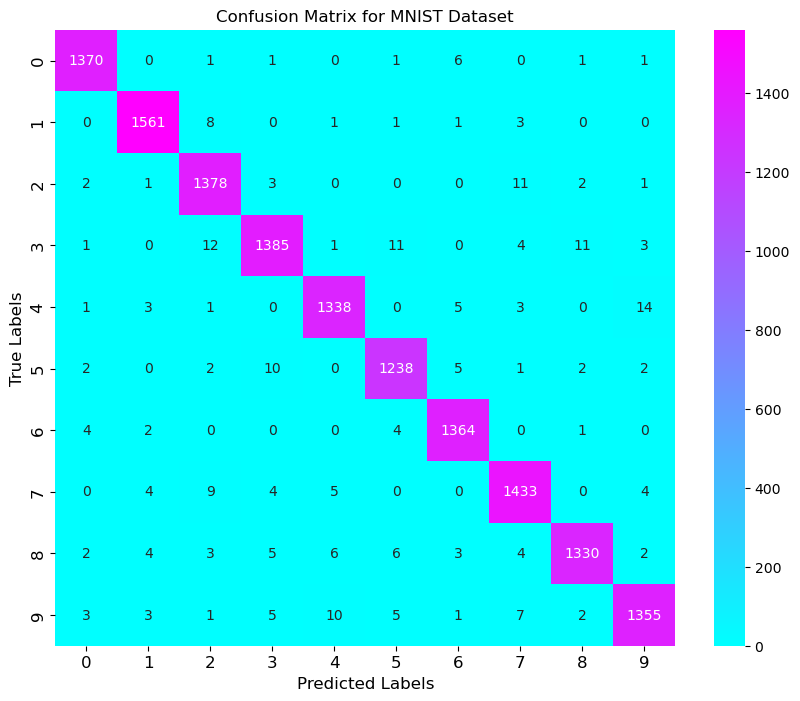

In [15]:
# Display the confusion matrix as a heatmap
plt.figure(figsize=(10, 8)) 
sns.heatmap(confusion_matrix_svc, annot=True, fmt='d', cmap='cool', cbar=True, 
            xticklabels= target_names, yticklabels= target_names)

plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for MNIST Dataset', fontsize=12)
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  

plt.show()

In [18]:
# Hur bra fungerar modelen på "ny data"
predictions = best_model.predict(X_test_sss)
confusion_matrix_best_model = confusion_matrix(y_test_sss, predictions)
classification_report_best_model = classification_report(y_test_sss, predictions)

In [20]:
print(classification_report_best_model)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1381
           1       0.99      0.99      0.99      1575
           2       0.98      0.98      0.98      1398
           3       0.99      0.98      0.98      1428
           4       0.98      0.98      0.98      1365
           5       0.98      0.98      0.98      1263
           6       0.99      0.99      0.99      1375
           7       0.98      0.98      0.98      1459
           8       0.98      0.98      0.98      1365
           9       0.97      0.97      0.97      1391

    accuracy                           0.98     14000
   macro avg       0.98      0.98      0.98     14000
weighted avg       0.98      0.98      0.98     14000



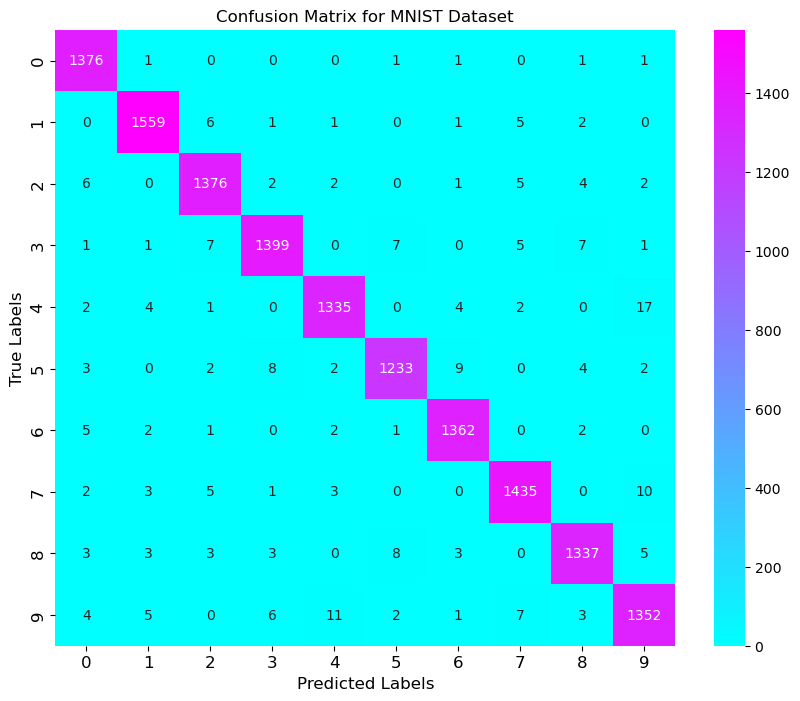

In [19]:
# Display the confusion matrix for "new" data as a heatmap
plt.figure(figsize=(10, 8)) 
sns.heatmap(confusion_matrix_best_model, annot=True, fmt='d', cmap='cool', cbar=True, 
            xticklabels= target_names, yticklabels= target_names)

plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for MNIST Dataset (new data)', fontsize=12)
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  

plt.show()

['best_model.joblib']